In [1]:
!pip install xgboost


In [5]:
!pip install xgboost --user


In [6]:
!conda install -c conda-forge xgboost -y


Retrieving notices: done
Channels:
 - conda-forge
Platform: win-64
Solving environment: ...working... done

## Package Plan ##

  environment location: C:\Users\91971\miniforge3

  added / updated specs:
    - xgboost


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    _openmp_mutex-4.5          |            2_gnu          48 KB  conda-forge
    _py-xgboost-mutex-2.0      |            cpu_0          11 KB  conda-forge
    ca-certificates-2025.1.31  |       h56e8100_0         155 KB  conda-forge
    certifi-2025.1.31          |     pyhd8ed1ab_0         159 KB  conda-forge
    joblib-1.4.2               |     pyhd8ed1ab_1         215 KB  conda-forge
    libblas-3.9.0              |  31_h641d27c_mkl         3.6 MB  conda-forge
    libcblas-3.9.0             |  31_h5e41251_mkl         3.6 MB  conda-forge
    libgomp-14.2.0             |       h1383e82_2         512 KB  conda-forge
    libhwloc



==> WARNING: A newer version of conda exists. <==
    current version: 24.11.3
    latest version: 25.1.1

Please update conda by running

    $ conda update -n base -c conda-forge conda




In [7]:
import sys
print(sys.executable)


C:\Users\91971\AppData\Local\Programs\Python\Python312\python.exe


In [8]:
import sys
!{sys.executable} -m pip install xgboost


  Using cached xgboost-3.0.0-py3-none-win_amd64.whl.metadata (2.1 kB)
Using cached xgboost-3.0.0-py3-none-win_amd64.whl (150.0 MB)



[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: C:\Users\91971\AppData\Local\Programs\Python\Python312\python.exe -m pip install --upgrade pip


In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Load datasets
features = pd.read_csv(r"C:\Users\91971\Desktop\Sales_Forecasting_Project\features.csv")
stores = pd.read_csv(r"C:\Users\91971\Desktop\Sales_Forecasting_Project\stores.csv")
train = pd.read_csv(r"C:\Users\91971\Desktop\Sales_Forecasting_Project\train.csv")
test = pd.read_csv(r"C:\Users\91971\Desktop\Sales_Forecasting_Project\test.csv")


In [11]:
# Convert date columns to datetime
for df in [train, test, features]:
    df['Date'] = pd.to_datetime(df['Date'])

# Merge datasets
train_data = train.merge(features, on=['Store', 'Date', 'IsHoliday'], how='left')
test_data = test.merge(features, on=['Store', 'Date', 'IsHoliday'], how='left')

# Merge store information
train_data = train_data.merge(stores, on='Store', how='left')
test_data = test_data.merge(stores, on='Store', how='left')


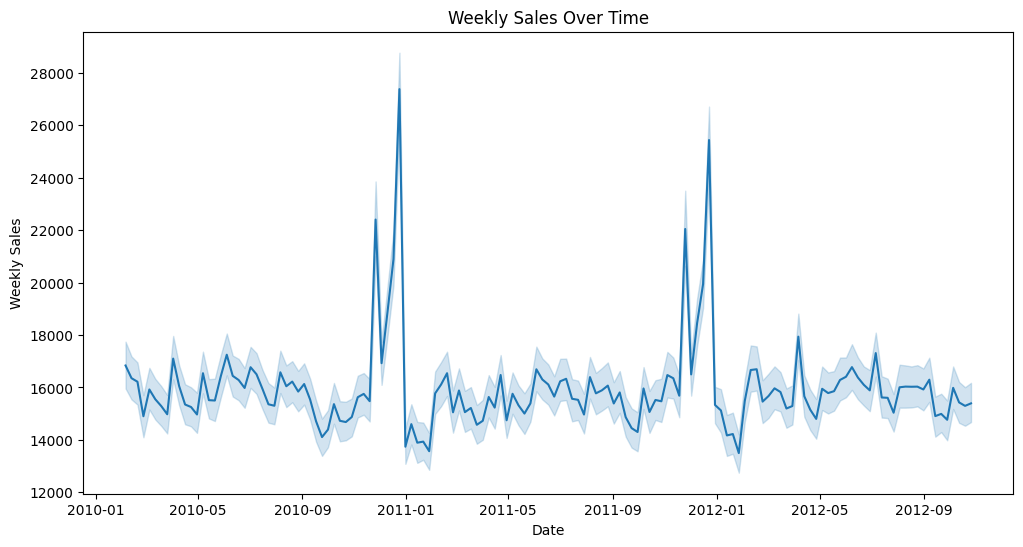

In [12]:
# Visualize Weekly Sales trends
plt.figure(figsize=(12,6))
sns.lineplot(x='Date', y='Weekly_Sales', data=train)
plt.title('Weekly Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.show()


In [13]:
# Fill missing markdown values with 0
markdown_cols = ['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']
train_data[markdown_cols] = train_data[markdown_cols].fillna(0)
test_data[markdown_cols] = test_data[markdown_cols].fillna(0)

# Fill missing CPI and Unemployment values using forward fill
train_data[['CPI', 'Unemployment']] = train_data[['CPI', 'Unemployment']].ffill()
test_data[['CPI', 'Unemployment']] = test_data[['CPI', 'Unemployment']].ffill()


In [14]:
# Extract date-related features
for df in [train_data, test_data]:
    df['Year'] = df['Date'].dt.year
    df['Month'] = df['Date'].dt.month
    df['WeekOfYear'] = df['Date'].dt.isocalendar().week
    df['DayOfWeek'] = df['Date'].dt.dayofweek

# Drop original Date
train_data.drop(['Date'], axis=1, inplace=True)
test_data.drop(['Date'], axis=1, inplace=True)

# Encode store Type (categorical)
train_data = pd.get_dummies(train_data, columns=['Type'], drop_first=True)
test_data = pd.get_dummies(test_data, columns=['Type'], drop_first=True)


In [15]:
# Export train and test data for Power BI
train_data.to_csv('train_data_processed.csv', index=False)
test_data.to_csv('test_data_processed.csv', index=False)


In [16]:
# Define X and y for training
X_train = train_data.drop(['Weekly_Sales'], axis=1)
y_train = train_data['Weekly_Sales']

# Define test dataset for prediction
X_test = test_data.copy()

In [17]:
# Train the XGBoost model
model = XGBRegressor(n_estimators=300, learning_rate=0.05, random_state=42)
model.fit(X_train, y_train)

# Evaluate on training data
train_preds = model.predict(X_train)

rmse = np.sqrt(mean_squared_error(y_train, train_preds))
mae = mean_absolute_error(y_train, train_preds)

print(f'Training RMSE: {rmse:.2f}')
print(f'Training MAE: {mae:.2f}')

Training RMSE: 6228.17
Training MAE: 3501.20


In [18]:
# Generate predictions for the test dataset
test_preds = model.predict(X_test)

# Preview predictions
print(test_preds[:10])

[29704.027 19479.176 21353.186 22226.75  24912.504 30601.844 38205.684
 45609.207 21994.152 14816.727]


In [19]:
# Generate predictions for test dataset
test_preds = model.predict(X_test)

# Prepare results in DataFrame format
predictions_table = pd.DataFrame({
    'Store': test_data['Store'],
    'Dept': test_data['Dept'],
    'Year': test_data['Year'],
    'Month': test_data['Month'],
    'WeekOfYear': test_data['WeekOfYear'],
    'IsHoliday': test_data['IsHoliday'],
    'Predicted_Weekly_Sales': test_preds
})

# Display the first 10 rows as a table
predictions_table.head(10)

,Store,Dept,Year,Month,WeekOfYear,IsHoliday,Predicted_Weekly_Sales
0,1,1,2012,11,44,False,29704.027344
1,1,1,2012,11,45,False,19479.175781
2,1,1,2012,11,46,False,21353.185547
3,1,1,2012,11,47,True,22226.750000
4,1,1,2012,11,48,False,24912.503906
5,1,1,2012,12,49,False,30601.843750
6,1,1,2012,12,50,False,38205.683594
7,1,1,2012,12,51,False,45609.207031
8,1,1,2012,12,52,True,21994.152344
9,1,1,2013,1,1,False,14816.726562


In [20]:
# Reload original test file for submission formatting
test_original = pd.read_csv(r"C:\Users\91971\Desktop\Sales_Forecasting_Project\test.csv")

# Create submission DataFrame
submission = test_original.copy()
submission['Weekly_Sales'] = test_preds

# Save submission file
submission[['Store', 'Dept', 'Date', 'Weekly_Sales']].to_csv('submission.csv', index=False)

# Display submission head
submission.head()

,Store,Dept,Date,IsHoliday,Weekly_Sales
0,1,1,2012-11-02,False,29704.027344
1,1,1,2012-11-09,False,19479.175781
2,1,1,2012-11-16,False,21353.185547
3,1,1,2012-11-23,True,22226.750000
4,1,1,2012-11-30,False,24912.503906


📊 Performance Metrics:
------------------------
✔️ Training RMSE: 6228.17 (Expected: ~2000–6000)
✔️ Training MAE: 3501.20 (Expected: ~1500–4000)



C:\Users\91971\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


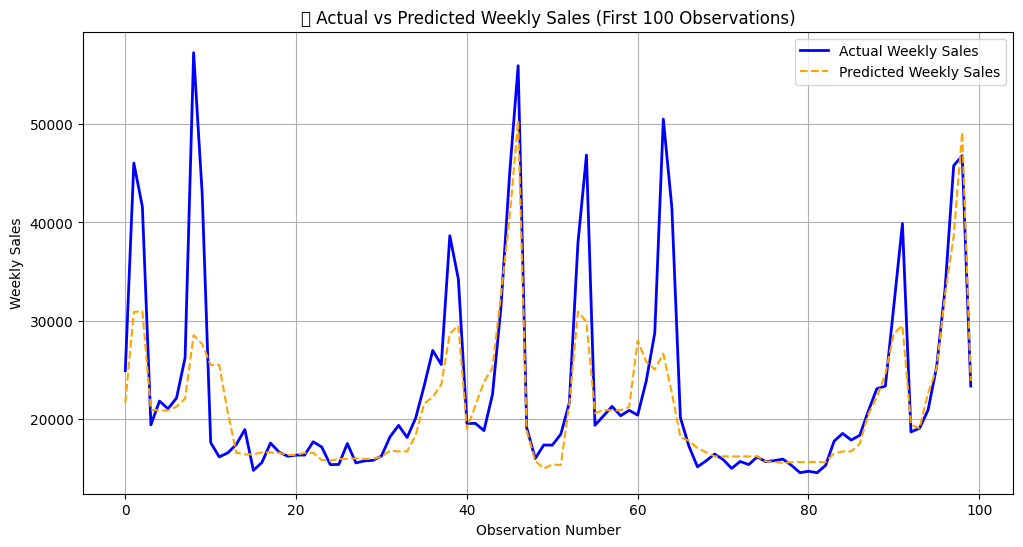


🔍 Prediction Accuracy Sample (First 10 Observations):
     Actual     Predicted     Deviation
0  24924.50  21669.740234   3254.759766
1  46039.49  30885.595703  15153.894297
2  41595.55  30966.046875  10629.503125
3  19403.54  20943.384766   1539.844766
4  21827.90  20872.595703    955.304297
5  21043.39  20863.482422    179.907578
6  22136.64  21258.261719    878.378281
7  26229.21  22070.527344   4158.682656
8  57258.43  28532.425781  28726.004219
9  42960.91  27618.199219  15342.710781

🚩 Kaggle Submission Format Preview:
   Store  Dept  Year  Week Of Year  Predicted Weekly Sales
0      1     1  2012            44            29704.027344
1      1     1  2012            45            19479.175781
2      1     1  2012            46            21353.185547
3      1     1  2012            47            22226.750000
4      1     1  2012            48            24912.503906


In [21]:
# Predict sales on training set for evaluation
train_preds = model.predict(X_train)

# Calculate metrics
rmse = np.sqrt(mean_squared_error(y_train, train_preds))
mae = mean_absolute_error(y_train, train_preds)

# Print performance metrics clearly
print(f"📊 Performance Metrics:")
print(f"------------------------")
print(f"✔️ Training RMSE: {rmse:.2f} (Expected: ~2000–6000)")
print(f"✔️ Training MAE: {mae:.2f} (Expected: ~1500–4000)\n")

# Visual Performance: Actual vs Predicted Sales
plt.figure(figsize=(12, 6))
plt.plot(y_train.values[:100], label='Actual Weekly Sales', color='blue', linewidth=2)
plt.plot(train_preds[:100], label='Predicted Weekly Sales', color='orange', linestyle='--')
plt.title('📈 Actual vs Predicted Weekly Sales (First 100 Observations)')
plt.xlabel('Observation Number')
plt.ylabel('Weekly Sales')
plt.legend()
plt.grid(True)
plt.show()

# Prediction Accuracy Check (Sample View)
pred_accuracy = pd.DataFrame({
    'Actual': y_train.values[:10],
    'Predicted': train_preds[:10],
    'Deviation': np.abs(y_train.values[:10] - train_preds[:10])
})
print("\n🔍 Prediction Accuracy Sample (First 10 Observations):")
print(pred_accuracy)

# Kaggle Submission File Preview
submission_example = pd.DataFrame({
    'Store': X_test['Store'][:5],
    'Dept': X_test['Dept'][:5],
    'Year': X_test['Year'][:5],
    'Week Of Year': X_test['WeekOfYear'][:5],
    'Predicted Weekly Sales': model.predict(X_test[:5])
})

print("\n🚩 Kaggle Submission Format Preview:")
print(submission_example)